In [1]:
import utils
import network
model_name     = 'deeplabv3plus_mobilenet'
num_classes    = 21
output_stride  = 16
separable_conv = False

In [2]:
# Set up model (all models are 'constructed at network.modeling)
#model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
#if separable_conv and 'plus' in model_name:
#    network.convert_to_separable_conv(model.classifier)
#utils.set_bn_momentum(model.backbone, momentum=0.01)

# Set up model (all models are 'constructed at network.modeling)
model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
if separable_conv and 'plus' in model_name:
    network.convert_to_separable_conv(model.classifier)
utils.set_bn_momentum(model.backbone, momentum=0.01)

In [3]:
import torch

ckpt = torch.load('checkpoints/best_deeplabv3plus_mobilenet_voc_os16.pth',map_location=torch.device('cpu'))['model_state']
model.load_state_dict(ckpt)

<All keys matched successfully>

In [4]:
from utils import ext_transforms as et
def get_dataset(dataset='voc',crop_size=256,crop_val=False,data_root='/home/irfan/Desktop/Data/VOCtrainval_11-May-2012'):
    """ Dataset And Augmentation
    """
    if dataset == 'voc':
        train_transform = et.ExtCompose([
            # et.ExtResize(size=opts.crop_size),
            et.ExtRandomScale((0.5, 2.0)),
            et.ExtRandomCrop(size=(crop_size, crop_size), pad_if_needed=True),
            et.ExtRandomHorizontalFlip(),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])
        if crop_val:
            val_transform = et.ExtCompose([
                et.ExtResize(crop_size),
                et.ExtCenterCrop(crop_size),
                et.ExtToTensor(),
                et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        else:
            val_transform = et.ExtCompose([
                et.ExtToTensor(),
                et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        train_dst = VOCSegmentation(root=data_root, year='2012',
                                    image_set='train', download=False, transform=train_transform)
        val_dst = VOCSegmentation(root=data_root, year='2012',
                                  image_set='val', download=False, transform=val_transform)

    if dataset == 'cityscapes':
        train_transform = et.ExtCompose([
            # et.ExtResize( 512 ),
            et.ExtRandomCrop(size=(crop_size, crop_size)),
            et.ExtColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            et.ExtRandomHorizontalFlip(),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        val_transform = et.ExtCompose([
            # et.ExtResize( 512 ),
            et.ExtToTensor(),
            et.ExtNormalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        ])

        train_dst = Cityscapes(root=data_root,
                               split='train', transform=train_transform)
        val_dst = Cityscapes(root= data_root,
                             split='val', transform=val_transform)
    return train_dst, val_dst


In [5]:
from torch.utils import data
from datasets import VOCSegmentation, Cityscapes
train_dst, val_dst = get_dataset()
#train_loader = data.DataLoader(
#    train_dst, batch_size=opts.batch_size, shuffle=True, num_workers=2,
#    drop_last=True)  # drop_last=True to ignore single-image batches.
val_loader = data.DataLoader(val_dst, batch_size=2, shuffle=True, num_workers=2)

/home/irfan/Desktop/Data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012
/home/irfan/Desktop/Data/VOCtrainval_11-May-2012/VOCdevkit/VOC2012


In [6]:
img,lbl=val_dst.__getitem__(0)

In [7]:
img.shape

torch.Size([3, 366, 500])

In [8]:
for img,lbl in val_loader:
    break

In [9]:
img.shape

torch.Size([2, 3, 375, 500])

In [10]:
pred=model(img)

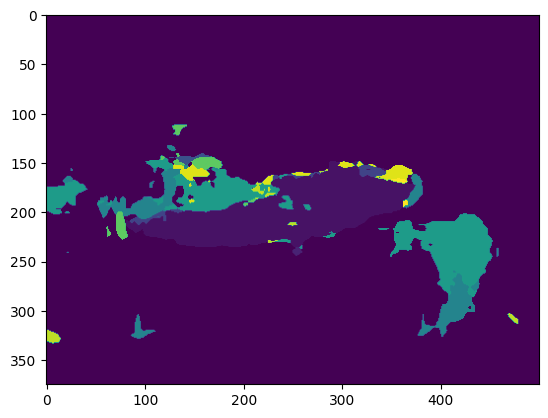

In [22]:
from matplotlib import pyplot as plt
plt.imshow(torch.argmax(pred[1].detach().cpu(),0))

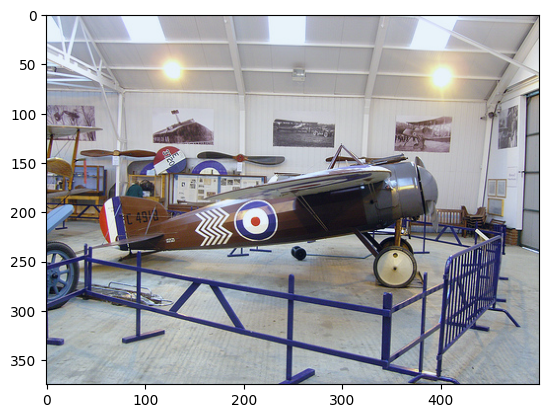

In [23]:
im = torch.permute(img[1].detach().cpu(),(1,2,0))
im = im - im.min()
im = im / im.max()
plt.imshow(im)